## v1.2: FNN Classification | 1 row as input | own test

### Importing Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 110)
import numpy as np
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder
%matplotlib inline

### Processing train.csv Dataset

In [2]:
df = pd.read_csv("train_data.csv")

# Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)

# Filtering events with len=1 or min_tca > 2 or max_tca < 2
df = df.groupby('event_id').filter(lambda x : x["time_to_tca"].min()<2.0)
df = df.groupby('event_id').filter(lambda x : x["time_to_tca"].max()>2.0)

# OHE for c_object_type (5 categories) -> 5 new features
df = pd.get_dummies(df)

# Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df = encoder.fit_transform(df)

df

,event_id,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
9,2,6.983474,0,0,0,0,1,-10.816161,-6.601713,13.293159,22902.0,14348.0,-1157.6,-6306.2,21986.3,15.8,-13792.0,-3957.1,1.0,0.0,3.92,3.92,444,442,99.4,1.094,3.4505,0.025520,0.009390,0.000019,7158.394530,0.000860,98.523094,-0.099768,0.357995,-0.122174,0.085472,-0.999674,0.121504,-0.999114,0.057809,-0.353866,-0.043471,-0.025138,0.087954,-0.430583,-0.088821,0.021409,180.0,2.0,13.87,13.87,15.0,15.0,100.0,1.838,0.814291,0.564380,0.000726,7168.396928,0.001367,69.717278,-0.068526,0.636970,-0.038214,0.064305,-0.999989,0.036762,-0.996314,0.153806,-0.634961,-0.149627,0.715984,-0.159057,0.953945,0.156803,-0.723349,12.0,2.0,786.417082,774.097978,800.056782,780.463075,63.955771,-16.008858,-0.063092,115.208802,4.110620e+06,2.715773e+18,9.039007,257.208281,147.615141,38173.433170,1.642649,218.243786,0.153332,39.695541,0.009370,0.269965,0.003886,0.339406,73.0,77.0,27.0,4.0,0,0,0,0,1
10,2,6.691611,0,0,0,0,1,-10.850473,-6.603452,13.374242,22966.0,14348.0,-1161.1,-6330.2,22046.3,15.8,-13792.0,-3957.1,1.0,0.0,3.86,3.86,444,442,99.4,1.099,3.4505,0.024168,0.010812,0.000017,7158.394561,0.000861,98.523097,-0.005874,0.360471,-0.036075,-0.002789,-0.999876,0.035870,-0.997255,-0.068114,-0.357012,0.076754,-0.027154,0.084268,-0.442266,-0.085037,0.020991,180.0,2.0,13.87,13.87,15.0,15.0,100.0,1.838,0.814291,0.564380,0.000726,7168.397641,0.001367,69.717278,-0.067750,0.636974,-0.038143,0.063521,-0.999989,0.036689,-0.996313,0.153053,-0.634998,-0.148865,0.715914,-0.158753,0.953971,0.156495,-0.723302,12.0,2.0,786.420510,774.094612,800.057080,780.464203,63.956674,-16.008858,-0.063092,101.429474,1.158624e+07,2.704770e+18,8.994890,257.185050,242.290796,38098.346421,1.675557,218.238631,0.252043,39.617319,0.009373,0.269926,0.003939,0.339393,73.0,77.0,27.0,4.0,0,0,0,0,1
11,2,6.269979,0,0,0,0,1,-30.000000,-6.217958,426.808532,18785.0,14347.0,-698.8,-5176.4,18044.8,14.4,-13791.4,-3957.2,1.0,0.0,3.85,3.85,447,445,99.4,1.113,3.4505,0.023038,0.009797,0.000016,7158.407962,0.000862,98.523100,-0.222621,0.425875,-0.149746,0.206756,-0.999517,0.147289,-0.999479,0.191052,-0.423717,-0.175085,0.082662,0.017007,-0.405439,-0.018617,-0.083820,1.0,0.0,14.63,14.63,15.0,15.0,100.0,1.641,0.849987,0.476139,0.000712,7168.395887,0.001297,69.718437,0.025977,0.563595,0.065183,-0.045196,-0.999602,-0.075887,-0.999774,-0.006036,-0.564147,0.025308,0.703561,-0.027022,0.916588,0.007301,-0.706289,12.0,2.0,786.439755,774.102169,799.554662,780.963112,63.903391,-16.009902,-0.057504,177.272242,3.780413e+06,7.644201e+13,9.927960,48.396653,121.934573,2521.604251,1.824402,86.921700,0.126831,2.616

In [3]:
# Getting y (last row of each event_id)
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)
print(y.shape)
y

(8892, 1)


array([[-30.        ],
       [-30.        ],
       [-27.65091683],
       ...,
       [-30.        ],
       [-30.        ],
       [ -7.1723723 ]])

In [4]:
# Getting X 
# Dropping rows with tca < 2 
X = df.loc[df["time_to_tca"]>2]

# Get last row
X = X.sort_values('time_to_tca',ascending=False).groupby('event_id').tail(1)
X = X.sort_values('event_id')

# First Approach: Drop all columns with any NaN value
X = X.dropna(axis=1, how='any')

# Set event_id as index
X.set_index("event_id", inplace=True)

X

,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2.340627,0,0,0,0,1,-30.000000,-6.266241,401.442549,18763.0,14347.0,-692.9,-5175.6,18022.2,14.4,-13791.4,-3957.2,1.0,0.0,3.49,3.49,501,500,98.9,1.059,0.019173,0.010743,0.000013,7158.408291,0.000863,98.523084,-0.051871,0.208553,0.036837,180.0,2.0,16.59,16.59,18.0,18.0,100.0,1.689,0.850363,0.474344,0.000693,7168.395618,0.001295,69.718480,-0.159121,0.540554,-0.046394,12.0,2.0,786.446298,774.096284,799.542232,780.975003,63.903222,-16.009902,-0.057504,227.820615,4.006767e+04,1.214045e+14,4.577326,51.249088,31.686243,2922.327839,1.414729,88.676852,0,0,0,0,1
3,2.278941,0,0,0,1,0,-30.000000,-7.320481,140.001151,23900.0,13574.0,26.3,10072.2,21674.9,-39.7,-12310.9,5718.9,1.0,0.0,7.56,7.56,240,238,99.9,1.118,0.015909,0.008274,0.000019,7083.606025,0.002115,98.151372,-0.598082,0.268787,-0.163112,180.0,2.0,17.17,17.17,15.0,15.0,100.0,2.484,0.418293,0.141765,0.000487,7070.079861,0.004569,70.872300,-0.451050,0.830112,-0.026392,1.5,2.0,720.452161,690.485888,724.249394,659.636329,-69.883198,24.916732,0.167568,287.224245,7.401362e+06,3.423533e+13,8.516651,59.235817,101.164964,3764.712472,4.090482,73.758993,1,0,0,0,0
4,3.066467,0,0,0,1,0,-30.000000,-7.661743,434.669432,33593.0,12093.0,163.6,-19727.8,27190.5,25.8,-9788.5,-7101.8,1.0,0.0,7.03,7.03,294,294,99.8,1.358,0.018361,0.025023,0.000029,7082.429604,0.003942,98.355121,-0.424212,-0.114650,0.114331,180.0,2.0,11.54,11.54,27.0,27.0,99.1,2.025,0.788613,0.441376,0.001403,7076.234143,0.004758,81.142435,-0.056333,0.647846,-0.090210,1.5,2.0,732.213546,676.371662,731.769073,664.425212,-79.277060,-35.961818,-0.122234,312.228924,1.184187e+07,9.184129e+12,7.063557,51.446030,85.238688,1952.448463,6.370385,39.768480,1,0,0,0,0
5,2.103772,0,0,0,1,1,-13.100070,-4.878440,23.068536,304.0,2001.0,-13.8,-301.3,-41.3,0.5,-268.6,1983.8,1.0,0.0,3.85,3.85,426,424,99.1,1.425,0.012823,0.008494,0.000026,6995.466922,0.000732,97.792706,-0.096565,0.347886,-0.016470,1.0,0.0,4.05,4.05,413.0,411.0,99.1,1.383,0.017372,0.003343,0.000039,6989.357563,0.000452,97.803378,-0.021236,0.147686,-0.009945,1.0,2.0,622.449242,612.210602,614.383062,608.058064,82.072936,82.289230,-0.014310,6.806426,9.228565e+04,9.333026e+04,5.400298,4.788862,33.080251,34.761214,1.822635,1.856012,0,1,0,0,0
6,2.040187,0,0,1,0,0,-30.000000,-5.079355,554.289715,10864.0,10027.0,139.5,-8143.1,-7190.7,8.7,-6638.6,7515.2,1.0,0.0,3.70,3.70,472,472,99.5,1.264,0.013325,0.003266,0.000012,7062.329276,0.000552,98.190676,-0.034148,0.194904,-0.016133,1.0,0.0,12.07,12.07,120.0,118.0,98.7,1.502,0.350748,0.182699,0.000239,7170.283365,0.014590,99.970882,0.022841,0.179192,-0.022222,21.0,2.0,688.093118,680.291434,896.758213,687.534518,77.696752,48.544024,-0.049711,194.076722,3.010363e+03,1.582295e+10,1.249624,15.298562,33.030864,458.641254,1.356105,18.233741,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [5]:
# Show distribution
def show_distrib(y_array, th):
    y_risk_class_ = np.where(y_array >= th, 1,0)
    sns.distplot(y_risk_class_)
    y_High_risk = np.sum(y_risk_class_==1)
    y_Low_risk = np.sum(y_risk_class_==0)
    y_risk_percent = 100*y_High_risk/(y_Low_risk+y_High_risk)
    print(f"High Risk: {y_High_risk}")
    print(f"Low Risk: {y_Low_risk}")
    print(f"Percent High Risk: {y_risk_percent}")

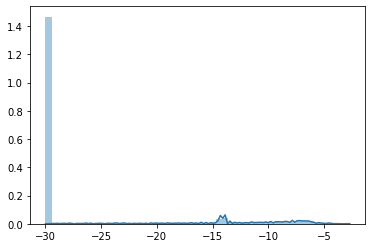

In [6]:
sns.distplot(y);

High Risk: 93
Low Risk: 8799
Percent High Risk: 1.0458839406207827


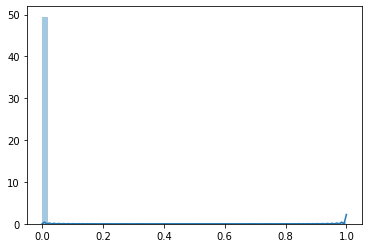

In [7]:
show_distrib(y, th=-6)

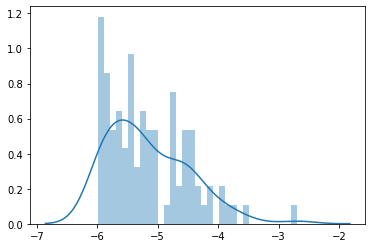

In [8]:
y_high_risk = y[np.where(y >= -6)]
sns.distplot(y_high_risk, bins=33);

### Get Train and Test data

In [9]:
y_risk_class = np.where(y >= -6, 1,0)

print(y_risk_class.shape)
y_risk_class

(8892, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test_real = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_risk_class)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test_real.shape)

(7113, 74)
(7113, 1)
(1779, 74)
(1779, 1)


In [11]:
y_train = np.where(y_train >= -6, 1,0)
print(y_train.shape)
y_train

(7113, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

High Risk: 74
Low Risk: 7039
Percent High Risk: 1.0403486573878813


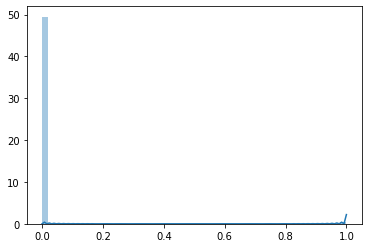

In [12]:
show_distrib(y_train, th=0.5)

In [13]:
y_test = np.where(y_test_real >= -6, 1,0)
print(y_test.shape)
y_test

(1779, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

High Risk: 19
Low Risk: 1760
Percent High Risk: 1.0680157391793141


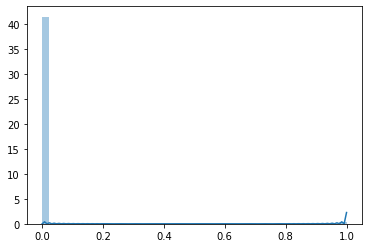

In [14]:
show_distrib(y_test, th=0.5)

In [15]:
# Scalers
X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

In [16]:
# Scaling X_train
X_train_scaled = X_train_scaler.fit_transform(X_train)
print(X_train_scaled.shape)
X_train_scaled

(7113, 74)


array([[4.33493700e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.73382860e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.74618626e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.98373549e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.13155141e-03, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.86919640e-02, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [17]:
# Scaling X_test
X_test_scaled = X_test_scaler.fit_transform(X_test)
print(X_test_scaled.shape)
X_test_scaled

(1779, 74)


array([[0.01256515, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02735843, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66493601, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.1255491 , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.90926743, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01492111, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

### Neural Network model

In [18]:
import tensorflow as tf
from tensorflow.keras import Model, optimizers, losses
from tensorflow.keras.layers import Input, Dense

In [19]:
# Model
input_shape = X_train_scaled.shape[1]
inputs_1 = Input(shape=(input_shape))
dense_1 = Dense(64, activation='relu')(inputs_1)
dense_2 = Dense(32, activation='relu')(dense_1)
dense_3 = Dense(16, activation='relu')(dense_2)
dense_4 = Dense(8, activation='relu')(dense_3)
output_1 = Dense(1, activation = 'sigmoid')(dense_4)

model_ffn = Model(inputs=inputs_1, outputs = output_1)

#opt = optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss_ = losses.binary_crossentropy

model_ffn.compile(optimizer=opt,loss = loss_, metrics =['accuracy'])
print(model_ffn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 74)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4800      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 7,553
Trainable params: 7,553
Non-trainable params: 0
___________________________________________________________

In [20]:
class_weight = {0: 0.0001,
                1: 0.1}

In [21]:
# Train
batch_size = 64
epochs = 350
model_ffn.fit(X_train_scaled, y_train, shuffle=True, 
              batch_size=batch_size, epochs=epochs, 
              class_weight=class_weight)

Train on 7113 samples
Epoch 1/350
7113/7113 [==============================] - 1s 150us/sample - loss: 3.4405e-04 - accuracy: 0.0104
Epoch 2/350
7113/7113 [==============================] - 0s 38us/sample - loss: 2.5978e-04 - accuracy: 0.0474
Epoch 3/350
7113/7113 [==============================] - 0s 35us/sample - loss: 1.9914e-04 - accuracy: 0.4042
Epoch 4/350
7113/7113 [==============================] - 0s 28us/sample - loss: 1.7775e-04 - accuracy: 0.5712
Epoch 5/350
7113/7113 [==============================] - 0s 30us/sample - loss: 1.4105e-04 - accuracy: 0.6217
Epoch 6/350
7113/7113 [==============================] - 0s 26us/sample - loss: 1.3022e-04 - accuracy: 0.6983
Epoch 7/350
7113/7113 [==============================] - 0s 27us/sample - loss: 1.1224e-04 - accuracy: 0.7162
Epoch 8/350
7113/7113 [==============================] - 0s 26us/sample - loss: 1.6230e-04 - accuracy: 0.6128
Epoch 9/350
7113/7113 [==============================] - 0s 26us/sample - loss: 1.4905e-04 - accu

7113/7113 [==============================] - 0s 45us/sample - loss: 4.7833e-05 - accuracy: 0.9006
Epoch 75/350
7113/7113 [==============================] - 0s 43us/sample - loss: 4.5507e-05 - accuracy: 0.9071
Epoch 76/350
7113/7113 [==============================] - 0s 41us/sample - loss: 6.8920e-05 - accuracy: 0.8645
Epoch 77/350
7113/7113 [==============================] - 0s 26us/sample - loss: 5.5505e-05 - accuracy: 0.8739
Epoch 78/350
7113/7113 [==============================] - 0s 25us/sample - loss: 4.4741e-05 - accuracy: 0.9069
Epoch 79/350
7113/7113 [==============================] - 0s 27us/sample - loss: 4.6507e-05 - accuracy: 0.9048
Epoch 80/350
7113/7113 [==============================] - 0s 30us/sample - loss: 5.0602e-05 - accuracy: 0.9033
Epoch 81/350
7113/7113 [==============================] - 0s 27us/sample - loss: 3.5510e-05 - accuracy: 0.9304
Epoch 82/350
7113/7113 [==============================] - 0s 26us/sample - loss: 1.1814e-04 - accuracy: 0.8146
Epoch 83/350
7

7113/7113 [==============================] - 0s 43us/sample - loss: 3.5899e-05 - accuracy: 0.9290
Epoch 148/350
7113/7113 [==============================] - 0s 47us/sample - loss: 3.7882e-05 - accuracy: 0.9234
Epoch 149/350
7113/7113 [==============================] - 0s 46us/sample - loss: 4.1428e-05 - accuracy: 0.9137
Epoch 150/350
7113/7113 [==============================] - 0s 43us/sample - loss: 3.7759e-05 - accuracy: 0.9459
Epoch 151/350
7113/7113 [==============================] - 0s 43us/sample - loss: 1.9433e-04 - accuracy: 0.7607
Epoch 152/350
7113/7113 [==============================] - 0s 43us/sample - loss: 1.2512e-04 - accuracy: 0.5951
Epoch 153/350
7113/7113 [==============================] - 0s 50us/sample - loss: 7.9273e-05 - accuracy: 0.7266
Epoch 154/350
7113/7113 [==============================] - 0s 53us/sample - loss: 6.5807e-05 - accuracy: 0.7950
Epoch 155/350
7113/7113 [==============================] - 0s 47us/sample - loss: 5.3840e-05 - accuracy: 0.8406
Epoch 

Epoch 220/350
7113/7113 [==============================] - 0s 28us/sample - loss: 4.6559e-05 - accuracy: 0.9231
Epoch 221/350
7113/7113 [==============================] - 0s 27us/sample - loss: 3.6409e-05 - accuracy: 0.9168
Epoch 222/350
7113/7113 [==============================] - 0s 27us/sample - loss: 3.0155e-05 - accuracy: 0.9356
Epoch 223/350
7113/7113 [==============================] - 0s 25us/sample - loss: 2.6696e-05 - accuracy: 0.9471
Epoch 224/350
7113/7113 [==============================] - 0s 26us/sample - loss: 2.7712e-05 - accuracy: 0.9484
Epoch 225/350
7113/7113 [==============================] - 0s 25us/sample - loss: 3.8743e-05 - accuracy: 0.9320
Epoch 226/350
7113/7113 [==============================] - 0s 26us/sample - loss: 2.8020e-05 - accuracy: 0.9459
Epoch 227/350
7113/7113 [==============================] - 0s 26us/sample - loss: 2.7574e-05 - accuracy: 0.9537
Epoch 228/350
7113/7113 [==============================] - 0s 24us/sample - loss: 1.1087e-04 - accuracy:

7113/7113 [==============================] - 0s 28us/sample - loss: 2.6964e-05 - accuracy: 0.9556
Epoch 293/350
7113/7113 [==============================] - 0s 30us/sample - loss: 1.5190e-04 - accuracy: 0.8673
Epoch 294/350
7113/7113 [==============================] - 0s 31us/sample - loss: 8.2688e-05 - accuracy: 0.7589
Epoch 295/350
7113/7113 [==============================] - 0s 28us/sample - loss: 4.3556e-05 - accuracy: 0.8747
Epoch 296/350
7113/7113 [==============================] - 0s 27us/sample - loss: 3.6671e-05 - accuracy: 0.9040
Epoch 297/350
7113/7113 [==============================] - 0s 26us/sample - loss: 3.0270e-05 - accuracy: 0.9279
Epoch 298/350
7113/7113 [==============================] - 0s 29us/sample - loss: 2.5821e-05 - accuracy: 0.9386
Epoch 299/350
7113/7113 [==============================] - 0s 25us/sample - loss: 2.5837e-05 - accuracy: 0.9404
Epoch 300/350
7113/7113 [==============================] - 0s 26us/sample - loss: 2.2068e-05 - accuracy: 0.9502
Epoch 

In [22]:
# Predict
predictions = model_ffn.predict(X_test_scaled)
predictions

array([[0.0000000e+00],
       [0.0000000e+00],
       [1.7881393e-07],
       ...,
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

In [23]:
'''import catboost
model_ml = catboost.CatBoostClassifier(verbose=False)
model_ml.fit(X_train_scaled, y_train)
predictions_ = model_ml.predict(X_test_scaled)
predictions_ = predictions_.reshape(-1, 1)
print(np.sum(predictions_==1))'''

'import catboost\nmodel_ml = catboost.CatBoostClassifier(verbose=False)\nmodel_ml.fit(X_train_scaled, y_train)\npredictions_ = model_ml.predict(X_test_scaled)\npredictions_ = predictions_.reshape(-1, 1)\nprint(np.sum(predictions_==1))'

In [24]:
predictions_ = np.where(predictions >= 0.5, -5, -30)
print(predictions_.shape)
predictions_

(1779, 1)


array([[-30],
       [-30],
       [-30],
       ...,
       [-30],
       [-30],
       [-30]])

In [25]:
predictions_classif = np.where(predictions >= 0.5, 1, 0)
print(predictions_classif.shape)
predictions_classif

(1779, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [26]:
'''predictions_ = np.asarray(X_test["risk"])
predictions_ = predictions_.reshape(-1, 1)
predictions_.shape'''

'predictions_ = np.asarray(X_test["risk"])\npredictions_ = predictions_.reshape(-1, 1)\npredictions_.shape'

Classification Report
              precision    recall  f1-score   support

    Low_Risk       0.99      0.97      0.98      1760
   High_Risk       0.12      0.42      0.18        19

    accuracy                           0.96      1779
   macro avg       0.56      0.69      0.58      1779
weighted avg       0.98      0.96      0.97      1779

Balanced Accuracy: 0.693
f1 score: 0.971
Confusion matrix
[[1700   60]
 [  11    8]]


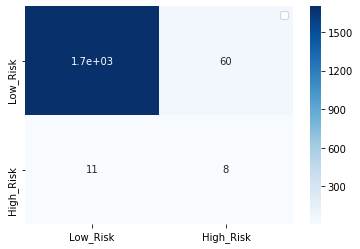

In [27]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, auc, roc_curve, balanced_accuracy_score

y_pred = predictions_classif
y = y_test

target_names = ['Low_Risk', 'High_Risk']
print('Classification Report')
print(classification_report(y, y_pred, target_names=target_names))
print('Balanced Accuracy: %.3f' % balanced_accuracy_score(y, y_pred))
print('f1 score: %.3f' % f1_score(y, y_pred, average='weighted'))
print('Confusion matrix')
cm = confusion_matrix(y, y_pred)
print(cm)
cmap = plt.cm.Blues
plt.legend(target_names)
hm = sns.heatmap(cm, annot=True, cmap=cmap, xticklabels=target_names, yticklabels=target_names)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, fbeta_score

'''
predicted = np.zeros(y_test.shape[0])
predicted.fill(-5)
predicted = predicted.reshape(-1, 1)
'''

predicted = predictions_
real = y_test_real

real_binary = []
predicted_binary = []

for a in list(real):
    if (a >= -6):
        real_binary.append(1)
    else:
        real_binary.append(0)
        
for a in list(predicted):
    if (a >= -6):
        predicted_binary.append(1)
    else:
        predicted_binary.append(0)

fscore = fbeta_score(real_binary, predicted_binary, 2)
print(f"F_score = {fscore}")
real_mse = real[np.where(real >= -6)]
predicted_mse = predicted[np.where(real >= -6)]

mse = mean_squared_error(real_mse, predicted_mse)
print(f"MSE = {mse}")

score = mse/fscore
print(f"F_Beta Score (Beta=2): {score}")

F_score = 0.2777777777777778
MSE = 356.9456167570932
F_Beta Score (Beta=2): 1285.0042203255355


In [29]:
'''df_submission = pd.DataFrame(predictions_,columns={"risk"})
df_submission.to_csv("submision_aaaa.csv", sep=",", index=False)'''

'df_submission = pd.DataFrame(predictions_,columns={"risk"})\ndf_submission.to_csv("submision_aaaa.csv", sep=",", index=False)'